In [27]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from draft2_updated_uzy import main
from rubin_sim.scheduler.utils import restore_scheduler, HpInLsstFov
from rubin_sim.scheduler.features import NObservations

In [2]:
class survey_args(object):
    def __init__(self, verbose=True, survey_length=365.25*10,
                outDir="", dbroot=None, maxDither=0.7,moon_illum_limit=40.,
                nexp=2,rolling_nslice=2,rolling_strength=0.9, gsw=3.0,
                ddf_season_frac=0.2, nights_off=6, nights_delayed=-1,
                neo_night_pattern=4, neo_filters='riz', neo_repeat=4):
        self.verbose = verbose
        self.survey_length=survey_length
        self.outDir=outDir
        self.dbroot=dbroot
        self.maxDither=maxDither
        self.moon_illum_limit=moon_illum_limit
        self.nexp=nexp
        self.rolling_nslice=rolling_nslice
        self.rolling_strength=rolling_strength
        self.gsw=gsw
        self.ddf_season_frac=ddf_season_frac
        self.nights_off=nights_off
        self.nights_delayed=nights_delayed
        self.neo_night_pattern=neo_night_pattern
        self.neo_filters=neo_filters
        self.neo_repeat=neo_repeat
        




In [3]:
args = survey_args(survey_length=0.)
observatory, scheduler, observations = main(args)

Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a
Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 0 observations
ran in 0 min = 0.0 hours


In [4]:
scheduler, observatory = restore_scheduler(200000, scheduler, observatory, 'draft2_updated_uzy_v2.99_10yrs.db')

In [5]:
conditions=observatory.return_conditions()

In [6]:
scheduler.survey_lists[0]

[<ScriptedSurvey survey_name='' at 0x7f7ae592aca0>,
 <ScriptedSurvey survey_name='' at 0x7f7ae592a790>]

In [7]:
temp_obs, temp_scheduler, temp_observations = main(args)

Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a
Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 0 observations
ran in 0 min = 0.0 hours


In [8]:
scheduler.survey_lists[2][3].survey_note

'blob, ri'

In [9]:
scheduler.survey_lists[2][3].basis_functions

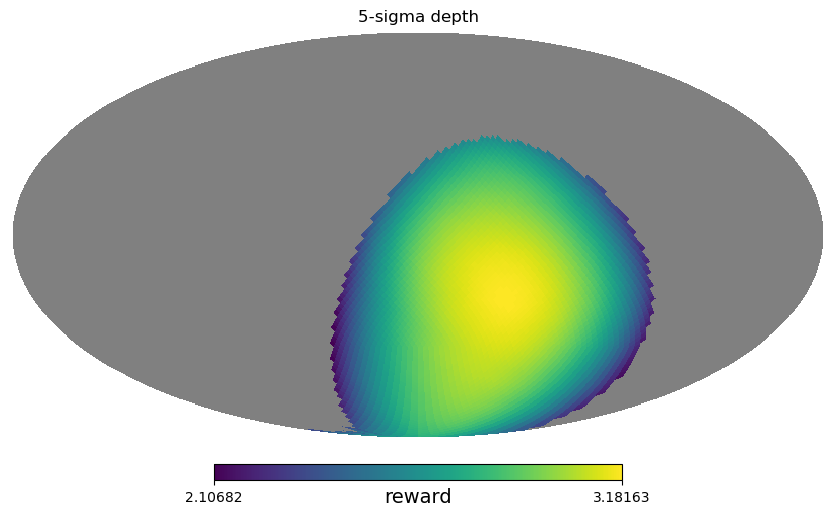

In [10]:
hp.mollview(scheduler.survey_lists[2][3].basis_functions[0](conditions),
            title='5-sigma depth', unit='reward')

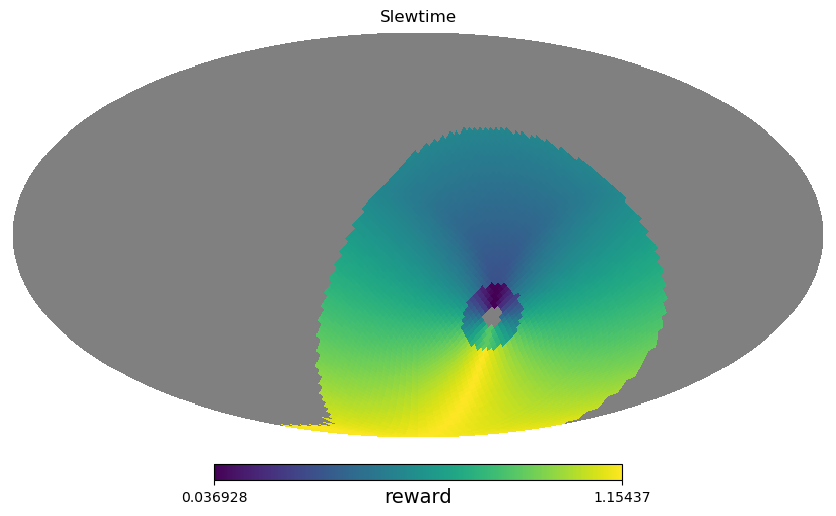

In [11]:
val = (scheduler.survey_lists[2][3].basis_functions[4](conditions))
val[np.where(val ==0)] = np.nan

hp.mollview(np.abs(val),
            title='Slewtime', unit='reward')

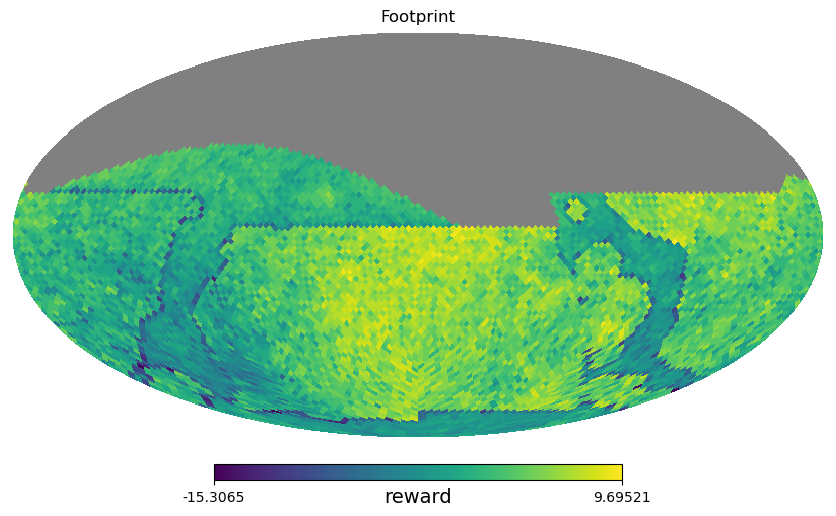

In [12]:
hp.mollview(scheduler.survey_lists[2][3].basis_functions[2](conditions),
            title='Footprint', unit='reward')

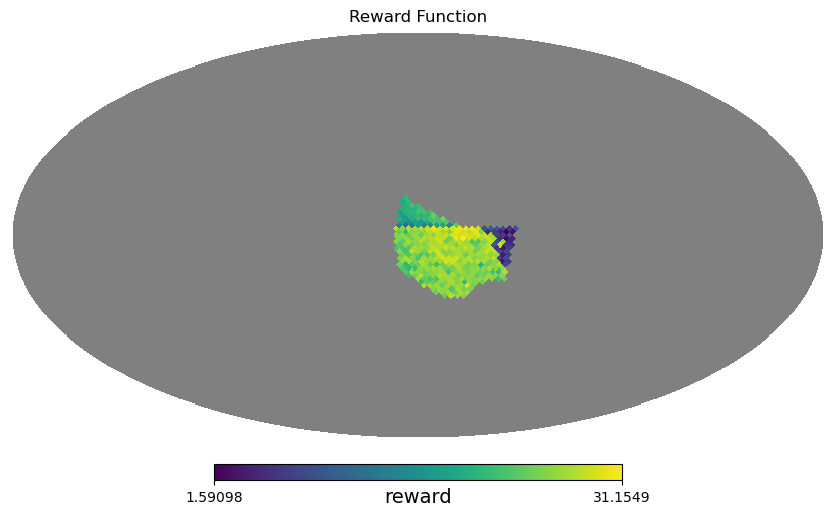

In [13]:
hp.mollview(scheduler.survey_lists[2][3].calc_reward_function(conditions), title='Reward Function', unit='reward')

In [57]:
# ok, let's call that survey and get a list of pointings
to_observe = scheduler.survey_lists[2][3].generate_observations(conditions)

In [58]:
# we can feed that into a feature object to make a map:
nside=128
pointing2hpindx = HpInLsstFov(nside=nside)
feature = NObservations(nside=nside)
for obs in to_observe:
    indx = pointing2hpindx(obs['RA'], obs['dec'])
    feature.add_observation(obs, indx=indx)


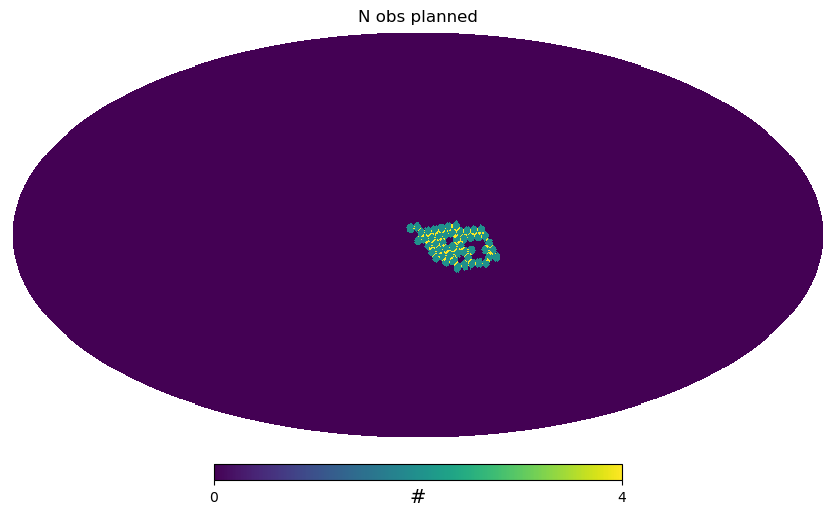

In [59]:
# Here's what the observations look like. Takes one observation at each position in r and i. 
# Spots with 4 are overlap regions (That gets us some sampling on 1-10 minute timescales).
hp.mollview(feature.feature, title='N obs planned', unit='#')

In [60]:
print(len(to_observe))

100


In [61]:
to_observe = np.concatenate(to_observe)


Text(0.5, 1.0, 'Observation Path')

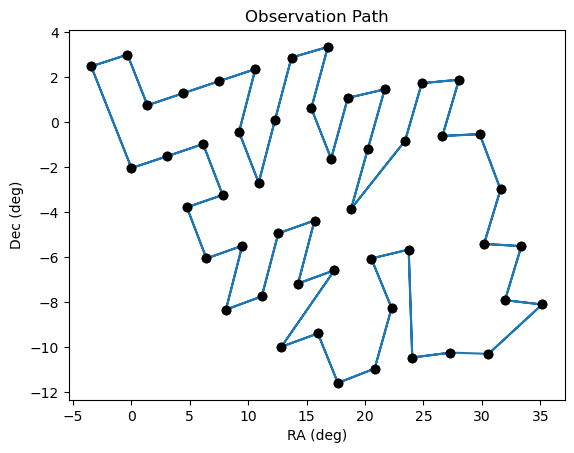

In [62]:
# fix wrap around ra=0
x = 360 - np.degrees(to_observe['RA'])
x[np.where(x > 180)] -= 360
plt.plot(x, np.degrees(to_observe['dec']))
plt.plot(x, np.degrees(to_observe['dec']), 'ko')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Observation Path')